In [27]:
import pandas as pd

# Load the customer and transaction data
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Convert `TransactionDate` to datetime
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [29]:
# Merge `customers` and `transactions` data on `CustomerID`
cust_transactions = pd.merge(customers, transactions, on='CustomerID')

In [31]:
# Calculate Recency, Frequency, and Monetary (RFM) features and other relevant metrics
rfm_features = cust_transactions.groupby('CustomerID').agg(
    N_Transactions=('TransactionID', 'nunique'),
    Total_Quantity=('Quantity', 'sum'),
    Total_Value=('TotalValue', 'sum'),
    Avg_Days_Between_Transactions=('TransactionDate', lambda x: (x.max() - x.min()).days / len(x) if len(x) > 1 else 0),
    N_Unique_Products=('ProductID', 'nunique')
).reset_index()

In [33]:
from sklearn.preprocessing import StandardScaler

# Standardize the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfm_features.drop(columns=['CustomerID']))

In [35]:
from sklearn.cluster import KMeans

In [37]:
from sklearn.metrics import davies_bouldin_score

# Find optimal number of clusters using Davies-Bouldin Index
best_dbi = float('inf')
best_n_clusters = None

for n_clusters in range(2, 11):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    labels = kmeans.labels_

    # Calculate Davies-Bouldin Index
    dbi = davies_bouldin_score(scaled_features, labels)

    if dbi < best_dbi:
        best_dbi = dbi
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters}, Davies-Bouldin Index: {best_dbi:.4f}")

Optimal number of clusters: 3, Davies-Bouldin Index: 0.7783


C:\Users\chand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\chand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\chand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\chand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

In [39]:
# Apply KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
kmeans.fit(scaled_features)
labels = kmeans.labels_

C:\Users\chand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [41]:
# Add cluster labels to the rfm_features DataFrame
rfm_features['Cluster'] = labels

# Group by `Cluster` and calculate mean for each feature
cluster_means = rfm_features.groupby('Cluster').agg(
    N_Transactions_mean=('N_Transactions', 'mean'),
    Total_Quantity_mean=('Total_Quantity', 'mean'),
    Total_Value_mean=('Total_Value', 'mean'),
    Avg_Days_Between_Transactions_mean=('Avg_Days_Between_Transactions', 'mean'),
    N_Unique_Products_mean=('N_Unique_Products', 'mean')
).reset_index()

# Print the cluster means
print(cluster_means.to_markdown(index=False, numalign="left", stralign="left"))

| Cluster   | N_Transactions_mean   | Total_Quantity_mean   | Total_Value_mean   | Avg_Days_Between_Transactions_mean   | N_Unique_Products_mean   |
|:----------|:----------------------|:----------------------|:-------------------|:-------------------------------------|:-------------------------|
| 0         | 7.14103               | 18.7436               | 5149.93            | 36.7899                              | 6.89744                  |
| 1         | 4.06931               | 9.84158               | 2664.99            | 61.6246                              | 4.0099                   |
| 2         | 1.6                   | 4.05                  | 956.891            | 8.575                                | 1.55                     |


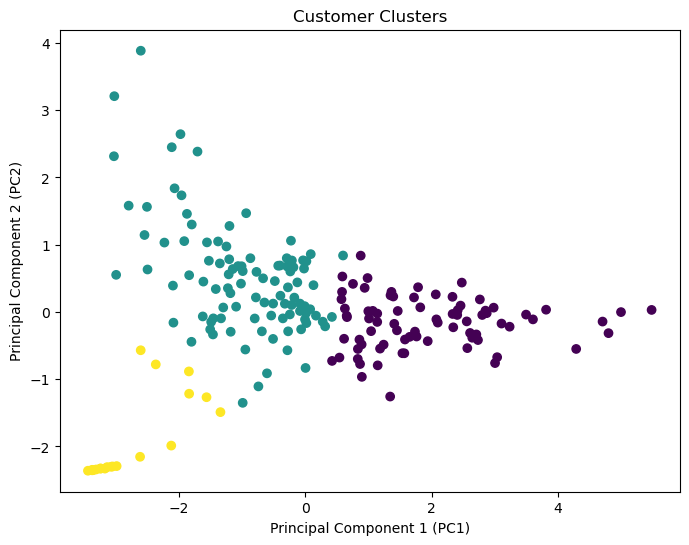

In [43]:
import matplotlib.pyplot as plt

# Scatter plot for `PC1` vs `PC2` colored by `Cluster`
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'])
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("Customer Clusters")

# Add tooltips (interactive labels)
annot = plt.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):
    pos = scatter.get_offsets()[ind["ind"]]
    annot.xy = pos
    text = ", ".join([f"{col}: {pca_df[col].iloc[n]}" for col in ("PC1", "PC2", "Cluster") for n in ind["ind"]])
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == plt.gca():
        cont, ind = scatter.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            plt.gcf().canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                plt.gcf().canvas.draw_idle()

plt.gcf().canvas.mpl_connect("motion_notify_event", hover)

plt.show()